In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import pymorphy2
from scipy.sparse import *
from gensim.parsing.preprocessing import *
import stop_words
from nltk.stem.snowball import RussianStemmer
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.stem import PorterStemmer, WordNetLemmatizer

%matplotlib notebook

In [2]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [3]:
match = re.fullmatch(r'\d\d\D\d\d', r'12-12') 
print('YES' if match else 'NO') 

YES


In [4]:
match = re.fullmatch(r'\d\d\D\d\d', r'Т. 12-12') 
print('YES' if match else 'NO') 

NO


In [5]:
print(re.split(r'\W+', 'Где, скажите мне, мои очки??!')) 

['Где', 'скажите', 'мне', 'мои', 'очки', '']


In [6]:
print(re.findall(r'\d\d\.\d\d\.\d{4}', 
                 r'Эта строка написана 21.01.2019, а могла бы и 01.09.2017')) 

['21.01.2019', '01.09.2017']


In [7]:
print(re.sub(r'\d\d\.\d\d\.\d{4}', 
             r'DD.MM.YYYY', 
             r'Эта строка написана 21.01.2019, а могла бы и 01.09.2017')) 

Эта строка написана DD.MM.YYYY, а могла бы и DD.MM.YYYY


In [8]:
re.findall(r'\w+$', 'AV is largest Analytics community of India')

['India']

In [9]:
re.findall(r'\w\w', 'AV is largest Analytics community of India')

['AV',
 'is',
 'la',
 'rg',
 'es',
 'An',
 'al',
 'yt',
 'ic',
 'co',
 'mm',
 'un',
 'it',
 'of',
 'In',
 'di']

In [10]:
re.findall(r'@\w+', 
           'abc.test@gmail.com, xyz@test.in, test.first@analyticsvidhya.com, first.test@rest.biz')

['@gmail', '@test', '@analyticsvidhya', '@rest']

In [11]:
re.findall(r'@\w+.\w+', 
           'abc.test@gmail.com, xyz@test.in, test.first@analyticsvidhya.com, first.test@rest.biz')

['@gmail.com', '@test.in', '@analyticsvidhya.com', '@rest.biz']

In [12]:
re.findall(r'@\w+.(\w+)', 
           'abc.test@gmail.com, xyz@test.in, test.first@analyticsvidhya.com, first.test@rest.biz')

['com', 'in', 'com', 'biz']

In [13]:
re.findall(r'[aeiouAEIOU]\w+', 'AV is largest Analytics community of India')

['AV', 'is', 'argest', 'Analytics', 'ommunity', 'of', 'India']

In [14]:
re.findall(r'\d([A-Z][A-Za-z]+)([A-Z][A-Za-z]+)', 
          '1NoahEmma2LiamOlivia3MasonSophia4JacobIsabella5WilliamAva6EthanMia7MichaelEmily')

[('Noah', 'Emma'),
 ('Liam', 'Olivia'),
 ('Mason', 'Sophia'),
 ('Jacob', 'Isabella'),
 ('William', 'Ava'),
 ('Ethan', 'Mia'),
 ('Michael', 'Emily')]

In [15]:
EXCLUDE_SYMBOLS_STR = u''.join(['№', '«', 'ђ', '°', '±', '‚', 'ћ', '‰', '…', '»', 'ѓ', 'µ', '·', 'ґ', 'њ', 'ї', 'џ', 'є', '‹',
                                '‡', '†', '¶', 'ќ', '€', '“', 'ў', '§', '„', '”', '\ufeff', '’', 'љ', '›', '•', '—', '‘', 
                                '\x7f', '\xad', '¤', '\xa0'])

In [16]:
GRAMMS = ['NOUN', 'ADJF', 'ADJS', 'PRTF', 'PRTS', 'GRND', 'ADVB']

In [17]:
DATA_PATH = 'corpus.csv'

In [18]:
df = pd.read_csv(DATA_PATH,index_col=0)
print(df.shape)

(200, 4)


In [19]:
df.head()

,14,3,5,7
0,"[<div class=""Text""><p>Компания «Яндекс» приобр...","[<div class=""Text""><p>Российская столица по до...","[<div class=""Text""><p>Российская столица по до...","[<div class=""Text""><p>Управлением Россельхозна..."
1,"[<div class=""Text""><p>Интеллектуальную транспо...","[<div class=""Text""><p>Мэр Москвы Сергей Собяни...","[<div class=""Text""><p>Малому бизнесу компенсир...","[<div class=""Text""><p>Более 40 территорий в ст..."
2,"[<div class=""Text""><p>Концепцию платформы прое...","[<div class=""Text""><p>Мэр Москвы Сергей Собяни...","[<div class=""Text""><p>Объем инвестиций в основ...","[<div class=""Text""><p>Россельхознадзор в Подмо..."
3,"[<div class=""Text""><p>Производитель развивающи...","[<div class=""Text""><p>Председатель Мосгордумы ...","[<div class=""Text""><p>Нижняя палата парламента...","[<div class=""Text""><p>Российская столица заним..."
4,"[<div class=""Text""><p>Федеральная служба по на...","[<div class=""Text""><p>В Совете Федерации подтв...","[<div class=""Text""><p>Заместитель председателя...","[<div class=""Text""><p>Пятилетняя девочка, кото..."


In [20]:
df.dtypes

14    object
3     object
5     object
7     object
dtype: object

---

In [22]:
corpus = []
for topic in df:
    corpus += df[topic].tolist()
    
answer_corpus = pd.Series(corpus)
answer_corpus = answer_corpus.apply(strip_tags)
answer_corpus = answer_corpus.apply(strip_multiple_whitespaces)
corpus = pd.Series(corpus)
corpus = corpus.apply(lambda x: x.lower())
corpus = corpus.apply(strip_tags)
corpus = corpus.apply(strip_punctuation2)
corpus = corpus.apply(strip_numeric)
corpus = corpus.apply(lambda x: re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', u' ', x))
corpus = corpus.apply(lambda x: re.sub('«|»', ' ', x))
corpus = corpus.apply(strip_multiple_whitespaces)
corpus

0       компания яндекс приобрела сервис вопросов и о...
1       интеллектуальную транспортную систему итс инн...
2       концепцию платформы проекта автодата по сбору...
3       производитель развивающих образовательных наб...
4       федеральная служба по надзору в сфере связи и...
5       федеральная антимонопольная служба фас россии...
6       в сувенирных магазинах московского метро стар...
7       операционная выручка оператора мобильной связ...
8       инновационный кластер москвы может стать площ...
9       ввод в эксплуатацию it платформы инновационно...
10      федеральная служба по надзору в сфере защиты ...
11      компания nextouch являющаяся резидентом особо...
12      вторая в этом году акция день без турникетов ...
13      уникальное приложение для онлайн трансляций л...
14      количество базовых станций операторов большой...
15      федеральная антимонопольная служба фас россии...
16      москва расширяет возможности для бесплатного ...
17      жители москвы в течение

In [23]:
print(len(corpus))


800


**Уберем лишние пробелы:**

In [24]:
corpus = np.asarray([doc.strip().strip('\t').replace('\n', u'') for doc in corpus])
print(len(corpus))

800


In [25]:
corpus[-1]

'авиакомпания utair начала продажу билетов по специальной цене на рейсы москва калининград и обратно для льготных категорий граждан сообщили в пресс службе перевозчика utair предлагает билеты из москвы в калининград и обратно по специальной цене для льготных категорий граждан от тыс руб в одну сторону полететь по сниженным ценам можно до апреля г билеты продаются в авиакассах калининграда москвы и других городов для покупки необходимо иметь документ подтверждающий льготу говорится в сообщении уточняется что билеты за тыс руб могут купить граждане российской федерации до лет мужчины старше и женщины старше лет инвалиды i группы любого возраста и сопровождающие их лица а также лица сопровождающие детей инвалидов и инвалиды с детства ii или iii группы кроме того льготные билеты могут приобрести лица имеющие удостоверение многодетной семьи или иные документы подтверждающие статус многодетной семьи в порядке установленном нормативными правовыми актами субъектов российской федерации'

**Уберем другие лишние символы:**

In [26]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [27]:
regex_punct = re.compile('[%s]' % re.escape(string.punctuation))
regex_dig = re.compile('[%s]' % re.escape(string.digits))
regex_symb = re.compile('[%s]' % re.escape(EXCLUDE_SYMBOLS_STR))
regex_struct = re.compile('[%s]' % string.printable + string.whitespace)
emoji_pattern = re.compile("["
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+")

In [28]:
corpus = [regex_punct.sub('', doc) for doc in corpus]
print(len(corpus))

800


In [29]:
corpus = [regex_dig.sub('', doc) for doc in corpus]
print(len(corpus))

800


In [30]:
corpus = [regex_symb.sub(' ', doc) for doc in corpus]
print(len(corpus))

800


In [31]:
corpus = [regex_struct.sub('', doc) for doc in corpus]
print(len(corpus))

800


In [32]:
corpus = [re.sub(' +' , ' ', doc.strip()) for doc in corpus]
print(len(corpus))

800


In [33]:
corpus[1]

'интеллектуальную транспортную систему итс инновационного центра сколково обновят ко ii кварталу г об этом журналистам сообщил президент некоммерческого партнерства глонасс соруководитель рабочей группы национальной технологической инициативы автонет александр гурко весной г нп глонасс начнется обновление интеллектуальной транспортной системы сколково новая версия системы позволит полностью автоматизировать многие процессы один из которых это управление транспортными потоками без участия человека уже во втором квартале текущего года пилотный проект обновленной интегрированной интеллектуальной системы будет запущен в сколково в г в ряде регионов рф сказал а гурко по его словам общая стоимость проекта составляет около млн руб внедрение системы позволит повысить качество жизни людей с снизит количество дтп и пробок на дорогах повысить эффективность и снизить затраты на управление транспортными и пассажирскими потоками также одна из целей проекта создание и вывод на российский и зарубежный

In [34]:
# texts = np.asarray([txt for doc, txt in zip(corpus, texts) if len(doc) > 0])
# print(len(texts))
corpus = np.asarray([doc for doc in corpus if len(doc) > 0])
print(len(corpus))

800


In [35]:
corpus = [doc.lower() for doc in corpus]
print(len(corpus))

800


In [36]:
corpus[-1]

'авиакомпания utair начала продажу билетов по специальной цене на рейсы москва калининград и обратно для льготных категорий граждан сообщили в пресс службе перевозчика utair предлагает билеты из москвы в калининград и обратно по специальной цене для льготных категорий граждан от тыс руб в одну сторону полететь по сниженным ценам можно до апреля г билеты продаются в авиакассах калининграда москвы и других городов для покупки необходимо иметь документ подтверждающий льготу говорится в сообщении уточняется что билеты за тыс руб могут купить граждане российской федерации до лет мужчины старше и женщины старше лет инвалиды i группы любого возраста и сопровождающие их лица а также лица сопровождающие детей инвалидов и инвалиды с детства ii или iii группы кроме того льготные билеты могут приобрести лица имеющие удостоверение многодетной семьи или иные документы подтверждающие статус многодетной семьи в порядке установленном нормативными правовыми актами субъектов российской федерации'

In [37]:
corpus = [emoji_pattern.sub('', doc) for doc in corpus]
print(len(corpus))

800


In [38]:
corpus[100]

'физкультурно оздоровительный центр откроют на территории особой экономической зоны технополис москва в печатниках февраля г сообщили в пресс службе департамента инвестиционной и промышленной политики столицы февраля на территории особой экономической зоны технополис москва в печатниках откроется новый физкультурно оздоровительный центр площадью тыс кв м в новом фоке заниматься споротом ежегодно смогут до тыс москвичей говорится в сообщении уточняется что фок будет удобно посещать сотрудникам компаний резидентов оэз технополис москва завода renault жителям районов печатники и кузьминки строительство спортивного центра проходило за счет средств инвестора общий объем инвестиций составил млн руб физкультурно оздоровительный комплекс aquastar расположен по адресу волгоградский проспект д в общую инфраструктуру комплекса входят метровый бассейн баня и сауна тренажерный зал с тремя зонами четыре зала групповых программ зона функционального тренинга залы для персональных занятий и консультаци

In [39]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [40]:
corpus_tokens = []
inds_to_drop = []

for i, sentence in enumerate(corpus[:]):
    tmp_tokens = []
    sp = sentence.split()
    for word in sp:
        if word not in stop_words.get_stop_words('ru'):
            if morph.word_is_known(word):
                tmp_tokens.append(word)
    if len(tmp_tokens) > 0:
        corpus_tokens.append(tmp_tokens)
    else:
        inds_to_drop.append(i)
#     break
        
print(len(corpus_tokens))#, len(texts))

800


In [41]:
answer_corpus = answer_corpus[~answer_corpus.index.isin(inds_to_drop)]
answer_corpus.index = pd.RangeIndex(len(answer_corpus))

In [42]:
stemmer = RussianStemmer()

*см. также  **лемамтизацию** в [pymorphy2](https://pymorphy2.readthedocs.io/en/latest/user/guide.html#normalization) и [nltk](https://www.nltk.org/api/nltk.stem.html?highlight=lemmatizer#nltk.stem.wordnet.WordNetLemmatizer)*

In [43]:
corpus_tokens_stem = []

for i, tokens in enumerate(log_progress(corpus_tokens[:])):
    tmp = [stemmer.stem(word) for word in tokens]
    corpus_tokens_stem.append(tmp)
#     break
    
print(len(corpus_tokens_stem))

800


In [45]:
corpus_tokens[100]

['физкультурно',
 'оздоровительный',
 'центр',
 'откроют',
 'территории',
 'особой',
 'экономической',
 'зоны',
 'технополис',
 'москва',
 'печатниках',
 'февраля',
 'сообщили',
 'пресс',
 'службе',
 'департамента',
 'инвестиционной',
 'промышленной',
 'политики',
 'столицы',
 'февраля',
 'территории',
 'особой',
 'экономической',
 'зоны',
 'технополис',
 'москва',
 'печатниках',
 'откроется',
 'новый',
 'физкультурно',
 'оздоровительный',
 'центр',
 'площадью',
 'тыс',
 'новом',
 'фоке',
 'заниматься',
 'споротом',
 'ежегодно',
 'смогут',
 'тыс',
 'москвичей',
 'говорится',
 'сообщении',
 'уточняется',
 'фок',
 'удобно',
 'посещать',
 'сотрудникам',
 'компаний',
 'резидентов',
 'технополис',
 'москва',
 'завода',
 'жителям',
 'районов',
 'печатники',
 'кузьминки',
 'строительство',
 'спортивного',
 'центра',
 'проходило',
 'счет',
 'средств',
 'инвестора',
 'общий',
 'объем',
 'инвестиций',
 'составил',
 'млн',
 'руб',
 'физкультурно',
 'оздоровительный',
 'комплекс',
 'расположен',
 

In [46]:
corpus_tokens_stem[100]

['физкультурн',
 'оздоровительн',
 'центр',
 'откроют',
 'территор',
 'особ',
 'экономическ',
 'зон',
 'технополис',
 'москв',
 'печатник',
 'феврал',
 'сообщ',
 'пресс',
 'служб',
 'департамент',
 'инвестицион',
 'промышлен',
 'политик',
 'столиц',
 'феврал',
 'территор',
 'особ',
 'экономическ',
 'зон',
 'технополис',
 'москв',
 'печатник',
 'откроет',
 'нов',
 'физкультурн',
 'оздоровительн',
 'центр',
 'площад',
 'тыс',
 'нов',
 'фок',
 'занима',
 'спорот',
 'ежегодн',
 'смогут',
 'тыс',
 'москвич',
 'говор',
 'сообщен',
 'уточня',
 'фок',
 'удобн',
 'посеща',
 'сотрудник',
 'компан',
 'резидент',
 'технополис',
 'москв',
 'завод',
 'жител',
 'район',
 'печатник',
 'кузьминк',
 'строительств',
 'спортивн',
 'центр',
 'проход',
 'счет',
 'средств',
 'инвестор',
 'общ',
 'обь',
 'инвестиц',
 'состав',
 'млн',
 'руб',
 'физкультурн',
 'оздоровительн',
 'комплекс',
 'располож',
 'адрес',
 'волгоградск',
 'проспект',
 'д',
 'общ',
 'инфраструктур',
 'комплекс',
 'вход',
 'метров',
 'бас

In [47]:
corpus_tokens_stem = np.asarray(corpus_tokens_stem)
# texts = np.asarray(texts)

print(len(corpus_tokens_stem))#, len(texts))

800


In [48]:
diffs = np.asarray([len(tokens) for tokens in corpus_tokens_stem])
print(len(diffs))

800


In [49]:
diffs

array([ 254,  168,  126,  123,  110,   90,  117,  137,  139,  135,  163,
        188,  252,  158,  121,   85,  123,  122,  135,  116,  157,  139,
        106,  115,   80,  191,   66,   58,  138,   65,  194,   73,  310,
        121,  111,   86, 1025,  123,   54,  128,   64,  148,  176,  168,
         88,  150,   83,   71,   58,   80,  129,   59,   61,  178,  145,
        141,  128,  140,  118,  327,  142,   52,  109,  112,  137,   73,
        165,  129,   91,  106,   90,  142,   82,  182,  117,  156,   67,
         84,   82,  267,  217,  150,   93,   94,  140,  131,  149,  154,
         91,  115,  127,  221,   83,  119,  215,   79,  130,  155,   73,
         84,  143,   57,  130,  152,  185,  161,   90,  160,   57,   85,
        128,   50,  125,   66,  105,  231,   39,   60,   67,  101,  144,
         73,  100,   94,   90,  155,   59,  263,  166,   46,   49,   60,
         46,   59,   71,  167,   96,   70,   60,   50,   61,   43,   75,
         66,   76,  100,   48,   98,   84,  201,  1

(0, 30)

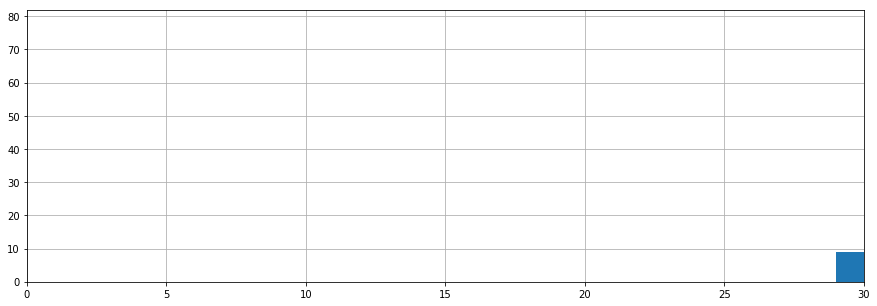

In [50]:
plt.figure(figsize=(15, 5))
plt.hist(diffs, bins=100)
plt.grid(True)
plt.xlim(0, 30)

In [51]:
corpus_tokens_stem[diffs == 2]

array([], dtype=object)

In [52]:
np.unique(corpus_tokens_stem).shape[0] / float(corpus_tokens_stem.shape[0])

0.92875

In [53]:
stat = {}

tmp_corp, tmp_texts = [], []

for i, tokens in enumerate(log_progress(corpus_tokens_stem)):
    s = ' '.join(tokens)
    if stat.get(s, None) is None:
        stat[s] = True
        tmp_corp.append(tokens)
        tmp_texts.append(corpus[i])
        
corpus_tokens_stem = tmp_corp
texts = tmp_texts
print(len(corpus_tokens_stem), len(texts))

743 743


In [54]:
corpus_tokens_stem = np.asarray(corpus_tokens_stem)

print(len(corpus_tokens_stem))#, len(texts))

743


In [55]:
diffs = np.asarray([len(tokens) for tokens in corpus_tokens_stem])
print(len(diffs))

743


(0, 10)

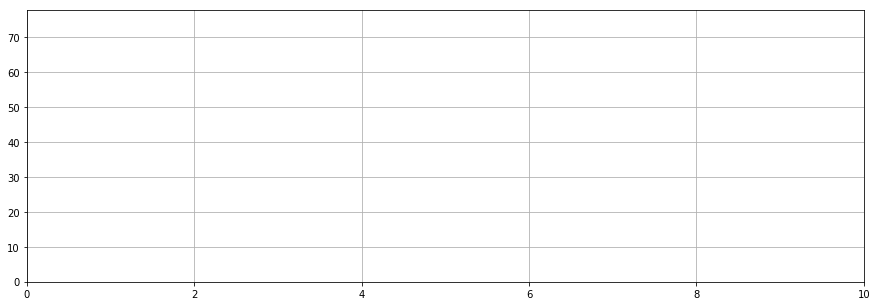

In [56]:
plt.figure(figsize=(15, 5))
plt.hist(diffs, bins=100)
plt.grid(True)
plt.xlim(0, 10)

In [57]:
corpus_tokens_stem[diffs == 7]

array([], dtype=object)

In [58]:
corpus_tokens_stem[diffs >= 8].shape

(743,)

In [59]:
corp4learning = corpus_tokens_stem[diffs >= 8]
# texts4learning = texts[diffs >= 8]

In [60]:
tmp_corp = []

for tokens in corp4learning:
    tmp_corp.append([t for t in tokens if len(t) > 2])
corp4learning = tmp_corp

In [61]:
vocab = np.unique(np.concatenate(corp4learning).flatten()).tolist()
print(len(vocab))

8690


In [62]:
real_vocab = dict.fromkeys(vocab,0)
for text in corp4learning:
    for word in text:
        real_vocab[word]+=1
top_used_vocab = pd.Series(real_vocab)
top_used_vocab.sort_values(ascending=False,inplace=True)
top_used_vocab.head()

москв    1084
тыс       807
служб     790
пресс     620
сообщ     588
dtype: int64

In [63]:
top100 = top_used_vocab.head(100).values

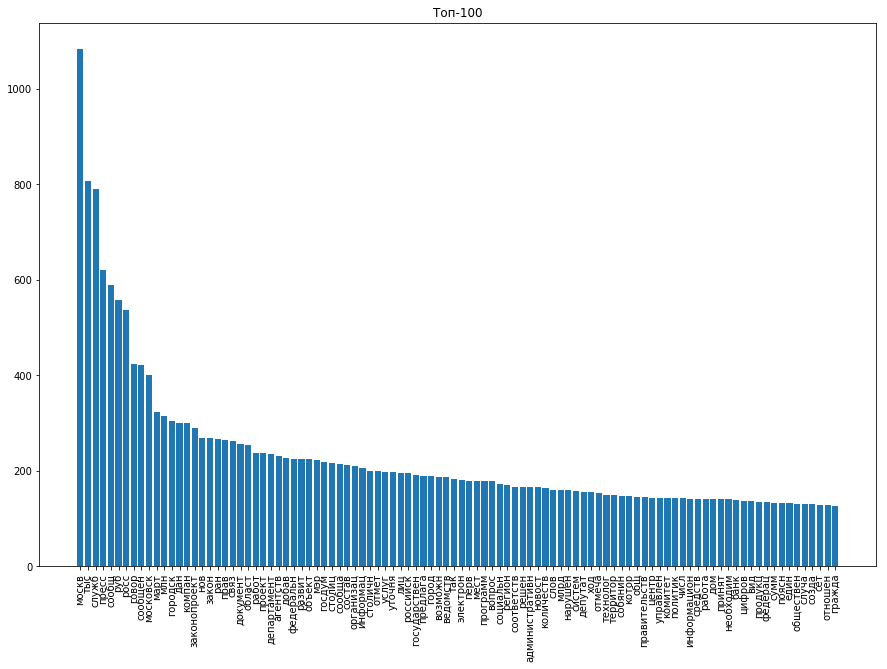

In [64]:
plt.figure(figsize=(15,10))
plt.bar(top_used_vocab.head(100).index,top_used_vocab.head(100).values)
plt.title('Топ-100')
plt.xticks(rotation='vertical');

### Удалим самые употребляемые

In [65]:
vocab.pop(vocab.index('москв'))

'москв'

In [66]:
vocab.pop(vocab.index('тыс'))

'тыс'

In [67]:
'москв' in vocab

False

In [68]:
serialised_vocab = pd.Series(vocab)

In [69]:
serialised_vocab

0                 абаз
1                абзац
2                абляц
3            абонемент
4           абонементн
5              абонент
6            абонентск
7            абрамович
8             абсолютн
9                абхаз
10             авансов
11                авар
12             аварийн
13              август
14           авиабилет
15       авиакатастроф
16          авиакомпан
17             авиалин
18        авиапассажир
19       авиаперевозок
20      авиаперевозчик
21          авиастроен
22      авиастроительн
23             авиатор
24               авиац
25            авиацион
26               австр
27             австрал
28                 авт
29             автобус
             ...      
8658               яйц
8659              якут
8660           ялтинск
8661           ямальск
8662             ямочн
8663          ямпольск
8664             январ
8665           январск
8666            яндекс
8667              япон
8668            японск
8669               ярк
8670       

In [70]:
corp_matrix = []
for text  in corp4learning:
    text_list = []
    for word in text:
        if word in serialised_vocab.values:
            text_list.append(serialised_vocab[serialised_vocab == word].index.values[0]) 
    corp_matrix.append(text_list)

In [71]:
corp_matrix

[[2838,
  8666,
  5888,
  6853,
  945,
  4610,
  5066,
  4335,
  8666,
  2258,
  61,
  1358,
  4155,
  7151,
  5756,
  6999,
  8666,
  8666,
  3126,
  6853,
  945,
  4610,
  4335,
  8666,
  2258,
  6658,
  4559,
  7657,
  6722,
  1739,
  6508,
  5310,
  8666,
  8345,
  458,
  5311,
  1076,
  8666,
  5601,
  576,
  4610,
  1317,
  7154,
  5756,
  6999,
  5605,
  4537,
  8666,
  3911,
  5323,
  5310,
  576,
  4610,
  2258,
  5413,
  3321,
  7868,
  5865,
  5060,
  1012,
  4218,
  200,
  2464,
  6328,
  945,
  4392,
  4610,
  3629,
  2133,
  5397,
  7314,
  754,
  576,
  4610,
  2258,
  5603,
  6508,
  5310,
  3570,
  5062,
  446,
  2795,
  576,
  4610,
  2262,
  1149,
  6245,
  6853,
  3834,
  4610,
  945,
  5397,
  8666,
  754,
  6508,
  5310,
  2694,
  4610,
  7025,
  576,
  7869,
  3916,
  1531,
  3759,
  6633,
  7410,
  6716,
  7027,
  5386,
  1787,
  4610,
  8544,
  5307,
  3324,
  640,
  5415,
  2349,
  3302,
  7155,
  8544,
  3925,
  6853,
  6154,
  1388,
  5417,
  2572,
  4610,
 